# Time series classification and clustering

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Overview

In this lecture we will cover the following topics:
- Introduction to classification and clustering.
- Similarity and dissimilarity measures and their impact in classification and clustering.
- Similarity measures for time series.
- Classification and clustering of time series.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq reservoir_computing tsa_course tck dtaidistance

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score, v_measure_score, pairwise_kernels, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import statsmodels.api as sm
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from tck.TCK import TCK
from tck.datasets import DataLoader
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.tensorPCA import tensorPCA
from reservoir_computing.modules import RC_model
from reservoir_computing.utils import compute_test_scores

---

## Classification and clustering

**Classification**

- Is a *supervised* task: a classifier uses external supervision to learn a task.
- The supervision usually consists of class information (labels).
- A classifier fits its parameters to predict the correct label. 
- This can be seen as learning where to put a decision boundary that separates the classes.

In [3]:
# Generate some toy data
data = datasets.make_blobs(n_samples=800, centers=[[-5,-7], [5,5], [-3,4]], cluster_std=[1.7, 2.5, 1.5], random_state=8)
X, y = data
X = StandardScaler().fit_transform(X)

In [4]:
def plot_class_example(X, y, gamma=1):
    _, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y), s=15, alpha=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

    clf = svm.SVC(kernel='rbf', gamma=gamma, C=1).fit(X, y)

    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min(), X[:, 0].max() 
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', linewidths=1.5, linestyles='dashed')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.tight_layout()
    plt.show()

- Most classifiers trade an accurate fit of the training data with generalization capabilities on out-of-sample data.
- The behavior is controlled by hyperparameters that are set through a validation procedure (and usually some experience).
- In this lecture we use [SVC](https://scikit-learn.org/stable/modules/svm.html), which is a [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) for classification.
- Try setting `gamma=20` in the example below to fit the training data better.

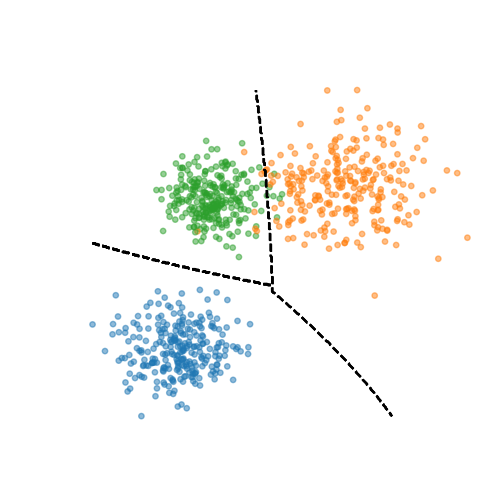

In [5]:
plot_class_example(X, y, gamma=0.1)

**Clustering**
- Is an *unsupervised* task.
- It only looks at the structure of the data without using additonal information (class labels, extra data, human knowledge, etc...).
- A clustering algorihtm groups data together so that each group is compact and separated from the others.
- Clustering gives insights about the structure of the data.
- The number of clutsers is often not given.

In [6]:
def plot_cluster_example(X, K=2):    
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
    clust_lab = kmeans.labels_
    centers = kmeans.cluster_centers_

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1], c='gray', s=15, alpha=0.5, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for ind,i in enumerate(centers):
            class_inds=np.where(clust_lab==ind)[0]
            max_dist=np.max(pairwise_distances(i[None, ...], X[class_inds]))
            plt.gca().add_artist(plt.Circle(i, max_dist*0.7, fill=False, color='tab:red', linewidth=2.0))

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title(f"{K} Clutsers")
    plt.tight_layout()
    plt.show()

- Setting the hyperparameters of clustering algorithms (and unsupervised approaches in general) is more critical than in supervised models.
- Differently from classification, there is not an *optimal* hyperparameter configuration.
- Here, we use the popular $k$-means algorithm.
- Try changing the number of clusters to `K=2` or to `K=4` in the code below.

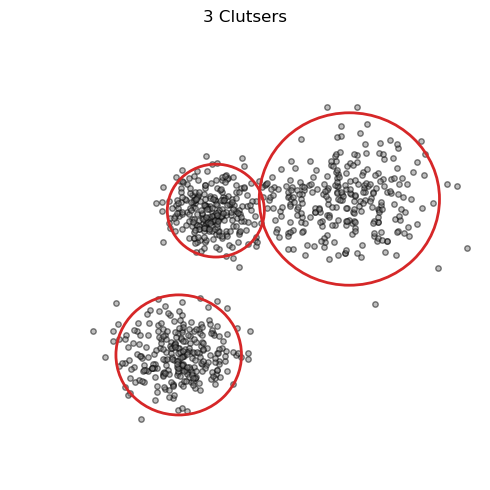

In [7]:
# We use the same data (X) as before, but not the labels (y)
plot_cluster_example(X, K=3)

### Performance metrics

- There are many metrics to evaluate the performance in classification and clustering tasks.
- The best ones to use depend on the problem at hand.
- Often more metrics should be considered at once.
- In this lecture we only consider:
    - accuracy and F1 score for classification,
    - NMI for clustering.

#### Classification

**Accuracy**
- Classification accuracy is the simplest way to measure of how well a classification model performs. 
- It's the ratio of correctly predicted observations to the total observations.

$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} =\frac{TP + TN}{TP + TN + FN +FP}$$

- Here, $TP$ true positives, $TN$ true negative, $FP$ false positives, and $FN$ false negatives.

In [8]:
# Split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the classifier
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)

# Compute predictions and accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.99


**F1 Score**
- The F1 Score is the harmonic mean of precision and recall, providing a balance between them. 
- It's used when the class distribution is uneven and you need a measure that takes both $FP$ and $FN$ into account.
- Is defined as:

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

- where 

$$\text{Precision} = \frac{TP}{TP + FP}$$ 

- and 

$$\text{Recall} = \frac{TP}{TP + FN}$$

<img src="media/precision-recall.png" style="width: 60%; display: block; margin: auto;">

<div style="text-align: center; font-size: 90%">Image: <a href="https://en.wikipedia.org/wiki/Precision_and_recall">Wikipedia</a></div>

- Let's create an imbalanced dataset.

In [9]:
n_samples_1 = 2000 # Samples of class 0
n_samples_2 = 100  # Samples of class 1

X_imb, y_imb = datasets.make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=[[0.0, 0.0], [2.0, 2.0]],
    cluster_std=[1.5, 0.5],
    random_state=0, shuffle=False)

In [10]:
# Split the data in training and test set
X_tr_imb, X_te_imb, y_tr_imb, y_te_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)

# Fit the classifier
clf = svm.SVC(kernel="linear", class_weight={1: 2}) # Try setting class_weight={1: 20}
clf.fit(X_tr_imb, y_tr_imb)

# Compute predictions and accuracy
y_pred_imb = clf.predict(X_te_imb)
print(f"Accuracy: {accuracy_score(y_te_imb, y_pred_imb):.2f}")

Accuracy: 0.96


- The accuracy score is very high... but are we doing well here?
- If we look closely, the classifier simply assigned all labels to the majority class.
- This is non acceptable in cases where the minority class is of interest.
- For example in anomaly detection.

In [11]:
print(f"Predictions of class 0: {(y_pred_imb==0).sum()}, predictions of class 1: {(y_pred_imb==1).sum()}")

print(f"F1 score: {f1_score(y_te_imb, y_pred_imb):.2f}")

Predictions of class 0: 400, predictions of class 1: 20
F1 score: 0.56


#### Clustering

**Normalized Mutual Information (NMI)**
- NMI is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). 
- It measures the agreement between the cluster assignments, $C$, and the class labels $Y$.

$$\text{NMI}(C, Y) = \frac{2 \times I(C; Y)}{H(C) + H(Y)}$$

- where $I(C; Y)$ is the MI between clusters and labels, and $H(C)$ and $H(Y)$ are the entropies of $X$ and $Y$, respectively.
- Note that the class labels are not used to form clusters but only to evaluate the results.
- If class labels are not available, one can still form clusters but not compute the NMI.
- That is not the case for classification algorithms.

In [12]:
# NMI for k-means with different values of k
clust_lab = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X).labels_
print(f"K=2, NMI: {v_measure_score(clust_lab, y):.2f}")

clust_lab = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X).labels_
print(f"K=3, NMI: {v_measure_score(clust_lab, y):.2f}")

clust_lab = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X).labels_
print(f"K=4, NMI: {v_measure_score(clust_lab, y):.2f}")

K=2, NMI: 0.73
K=3, NMI: 0.92
K=4, NMI: 0.84


---

## Similarity and dissimilarity measures

### Dissimilarity measures

- Quantify how different two objects are: the higher their dissimilarity, the more different they are. 
- Dissimilarity measures are crucial to distinguish between distinct groups of data or identify outliers. 
- The most common linear dissimilarity measure is the Euclidean distance:

$$d(\mathbf{x}, \mathbf{y}) = \| \mathbf{x} - \mathbf{y} \|_2$$

- Also important is the Mahalanobis distance:

$$d(\mathbf{x}, \mathbf{y}) = \sqrt{(\mathbf{x} - \mathbf{y})^\top \Sigma^{-1}(\mathbf{x} - \mathbf{y})}$$

- which reduces to the Euclidean distance when the covariance matrix is $\Sigma^{-1}=\mathbf{I}$.

### Similarity measures

- A similarity measure quantifies how similar two objects are: the higher the value, the more similar the objects. 
- These measures are essential in algorithms that rely on the concept of *closeness* or *similarity* to make decisions, such as recommender systems. 
- An example of similarity measures is the cosine similarity:

$$s(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \| \mathbf{y}\|}$$

- Another example is the Pearson correlation coefficient, used in statistics to measure the linear correlation between two variables:

$$s(\mathbf{x}, \mathbf{y}) = \frac{\text{cov}(\mathbf{x}, \mathbf{y})}{\sigma_\mathbf{x}, \sigma_\mathbf{y}}$$

### Linear and non-linear measures
- The measures we described so far are *linear*.
- It means that their computation follows a linear relationship with respect to the data. 
- Some measures, instead, are *non-linear*, meaning that the relationship between the measure and the data does not follow a straight line.
- **Kernels** are examples of non-linear similarity measures.
- The most famous kernel is the Radial Basis Function (RBF): 

$$s(\mathbf{x}, \mathbf{y}) = \text{exp}\left( -\gamma \| \mathbf{x} - \mathbf{y} \|^2 \right)$$

- The parameter $\gamma$ is the *kernel width*, which controls the std. dev. of the Gaussian.
- Setting it properly is crucial for defining distances: smaller values will account for relationshiops between distant objects.

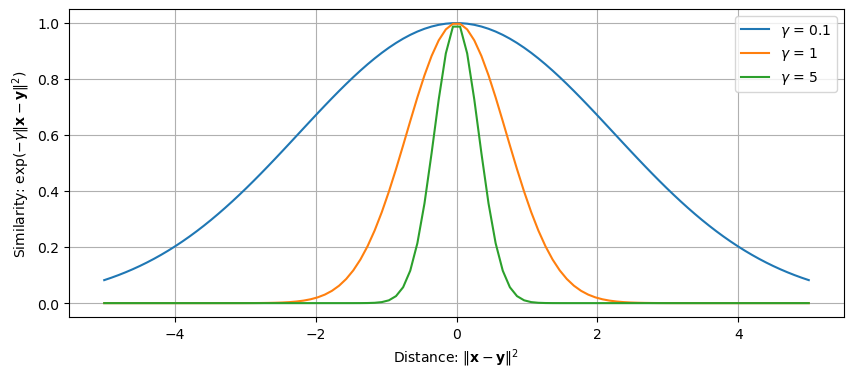

In [13]:
values = np.linspace(-5, 5, 100)
gamma_vals = [0.1, 1, 5]
plt.figure(figsize=(10, 4))
for gamma in gamma_vals:
    similarity = np.exp(-gamma * values**2)
    plt.plot(values, similarity, label=f'$\gamma$ = {gamma}')
plt.xlabel('Distance: $\|\mathbf{x} - \mathbf{y}\|^2$')
plt.ylabel('Similarity: $\exp(-\gamma\|\mathbf{x} - \mathbf{y}\|^2)$')
plt.legend()
plt.grid(True);

- The choice of similarity or dissimilarity measure is critical in classification and clustering problems.
- The measure directly affects how well an algorithm can identify structures in the data. 
- An inappropriate choice might lead to poor classification or clustering performance because the measure may not capture the actual relationships among data points.

### Effect on classification

- In the following we generate some toy data and compute a similarity matrix using a linear and a nonlinear measure.
- As linear measure, we will use the cosine similarity.
- As non-linear measure we will use an RBF kernel.

In [14]:
X, y = datasets.make_circles(noise=0.2, factor=0.5, 
                             random_state=1, n_samples=200) # Create toy data
X_train , X_test , y_train, y_test = train_test_split(X, y, 
                                                      random_state=0) #Train-test split

# Cosine similarity matrix
cosine_train = cosine_similarity(X_train)

# RBF similarity matrix
rbf_kernel_train = pairwise_kernels(X_train, metric='rbf', gamma=0.5)

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
axes[0].set_title("Input data")
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.6, edgecolors="k")
axes[0].set_xticks(())
axes[0].set_yticks(())

# Plot the cosine matrix
idx = np.argsort(y_train)
axes[1].imshow(cosine_train[idx][:, idx], cmap='viridis')
axes[1].set_title("Cosine similarity matrix (linear)")

# Plot the RBF matrix
axes[2].imshow(rbf_kernel_train[idx][:, idx], cmap='viridis')
axes[2].set_title("RBF kernel matrix (nonlinear)");

- We see that the two classes appear more separated when using a nonlinear similarity.

- Next, we will train an SVM classifier that uses these two similarity measures.
- We will look at the decision boundaries learned by the classifier and compute its performance on the test data.
- For the RBF kernel, we will use both $\gamma=0.5$ and $\gamma=0.1$.

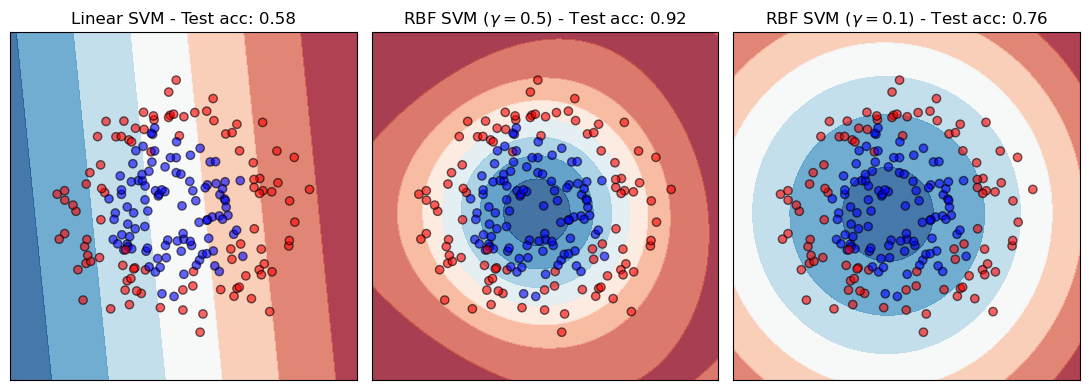

In [16]:
classifiers = [svm.SVC(kernel="linear"), svm.SVC(gamma=0.5), svm.SVC(gamma=0.1)]
names = ["Linear SVM", "RBF SVM ($\gamma=0.5$)", "RBF SVM ($\gamma=0.1$)"]
figure = plt.figure(figsize=(11, 4))
for i, (name, clf) in enumerate(zip(names, classifiers)):
    ax = plt.subplot(1,3,i+1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.6)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name + f" - Test acc: {score:.2f}")
plt.tight_layout();

- Also in this case, the impact in using different similarity measures is quite big.

#### Effect on clustering

- Being clustering an unsupervised task the impact of the (dis)similarity measures is even larger.
- The lack of training exacerbate the effect of choosing a bad (dis)similarity.
- Samples get grouped very differently based on what makes them (dis)similar.

- In the next example, we look at *hierarchical clustering* (HC).
- The idea of HC is to progressively form clusters by grouping together samples within a certain distance radius.
- In the beginning, the radius is very small and many distinct clusters are formed.
- As the radius increases, further points are grouped together and the number of clusters decreases.

- Let us consider the following data and compute a squared Euclidean distance matrix.
- As HC algorithm we will use the *Ward Linkage*, which gradually aggregate clusters by optimizing the [minimum variance criterion](https://en.wikipedia.org/wiki/Ward%27s_method#The_minimum_variance_criterion).
    - At each step it finds the pair of clusters that leads to minimum increase in the total within-cluster variance after merging.

In [17]:
X, y = datasets.make_blobs(n_samples=1500, centers=4, 
                           cluster_std=[1.7, 2.5, 0.5, 1.5], random_state=2)
X = StandardScaler().fit_transform(X) # Normalizing the data facilitates setting the radius

# Compute the distance matrix
Dist = pairwise_distances(X, metric="sqeuclidean")
distArray = ssd.squareform(Dist)

# Compute the hierarchy of clusters
Z = linkage(distArray, 'ward')

- By setting a different radius (threshold) we obtain different partitions.
- Let's try as thresholds `t=10` and `t=30`.

In [18]:
partition_1 = fcluster(Z, t=10, criterion="distance")
print("Partition 1: %d clusters"%len(np.unique(partition_1)))

partition_2 = fcluster(Z, t=30, criterion="distance")
print("Partition 1: %d clusters"%len(np.unique(partition_2)))

Partition 1: 8 clusters
Partition 1: 4 clusters


In [19]:
def plot_clusters(data, clusters=None, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    color = 'gray' if clusters is None else plt.cm.tab10(clusters)
    ax.scatter(data[:, 0], data[:, 1], c=color, s=15, alpha=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    ax.set_title(title)

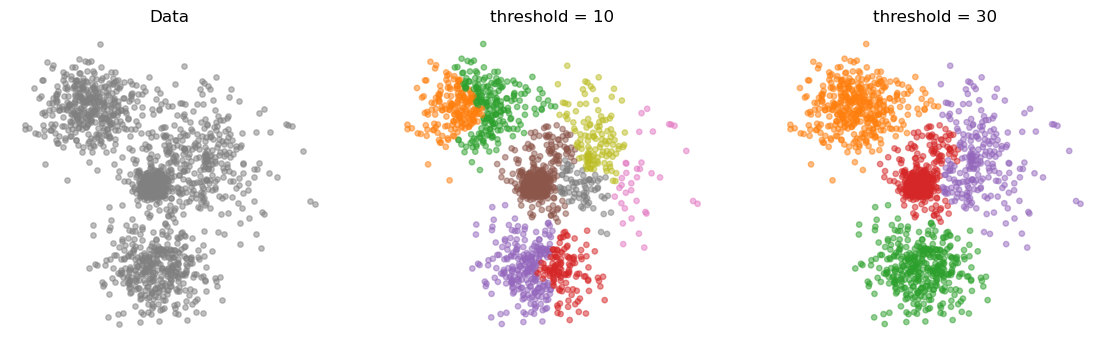

In [20]:
_, axes = plt.subplots(1,3, figsize=(14,4))
plot_clusters(X, title="Data", ax=axes[0])
plot_clusters(X, title="threshold = 10", clusters=partition_1, ax=axes[1])
plot_clusters(X, title="threshold = 30", clusters=partition_2, ax=axes[2])

- It is possible to visualize the hierarchy generated by HC.
- It is also possible to color the branches based on the threshold value.
- This is a very useful tool to examine the structure in the data at different resolutions.

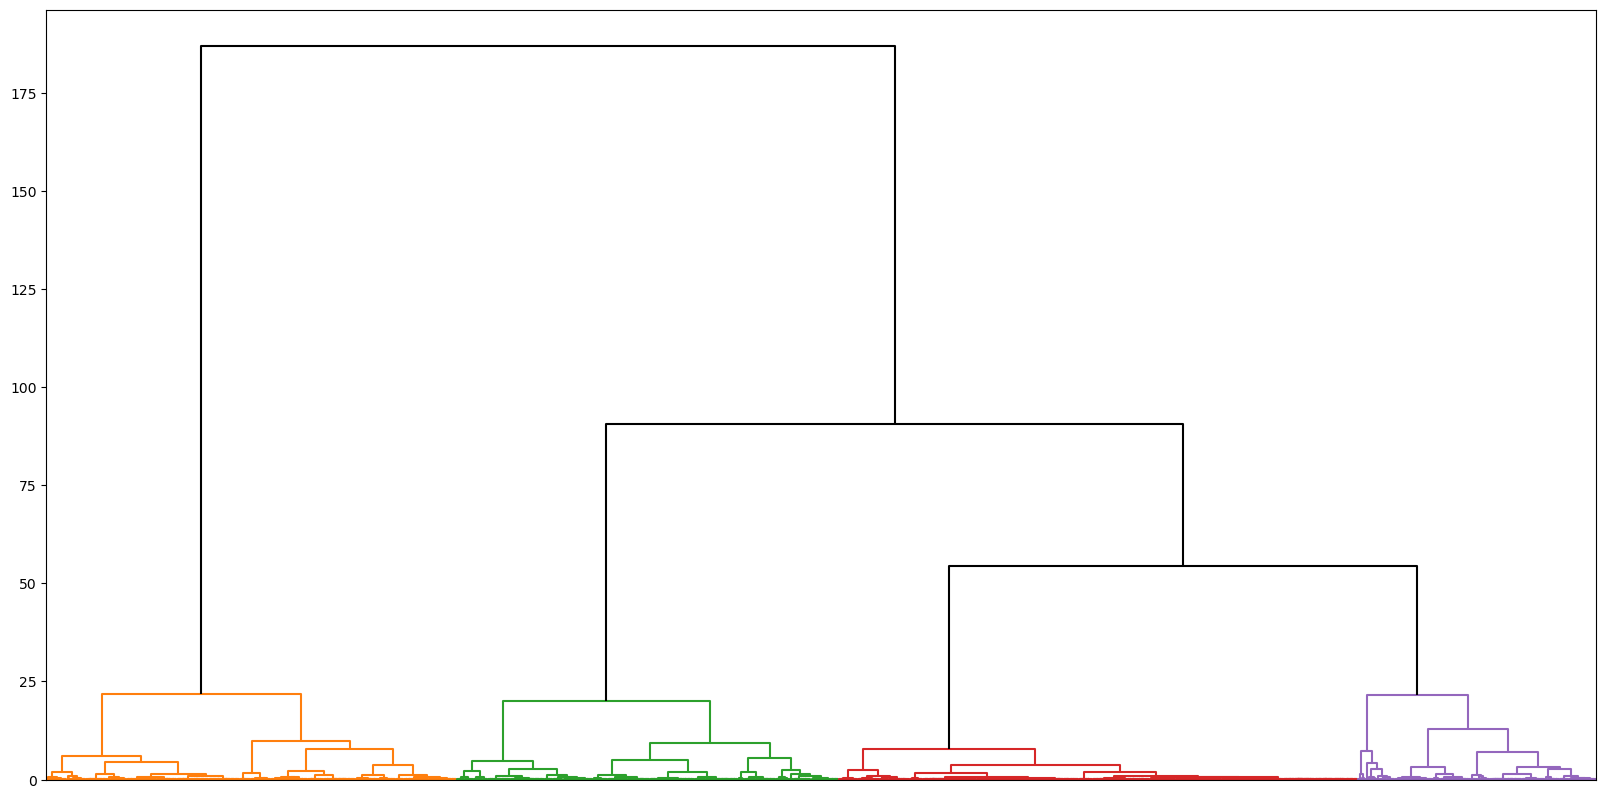

In [21]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=30, above_threshold_color='k', 
                show_leaf_counts=False)
plt.xticks([]);

- Partitions that persist for broad ranges of values of the threshold are those that characterize the dataset the most.

- Finally, let's see the effect of using different distance metrics.
- We will use an RBF kernel as before and a Mahalanobis distance that weights each feature differently.

In [22]:
# Compute the RBF (note that we must convert it to a distance)
rbf_kernel = pairwise_kernels(X, metric='rbf', gamma=1.0) # compute the rbf similarity
rbf_kernel = rbf_kernel + rbf_kernel.T # make symmetric
rbf_kernel /= rbf_kernel.max() # normalize to [0, 1]
rbf_dist = 1.0 - rbf_kernel # convert to distance
np.fill_diagonal(rbf_dist, 0) # due to numerical errors, the diagonal might not be 0

# Compute the partition
distArray = ssd.squareform(rbf_dist)
Z = linkage(distArray, 'ward')
partition_3 = fcluster(Z, t=3, criterion="distance")

In [23]:
# Mahalanobis distance that assigns different weights to the features
weights = np.array([1, 0.1])
Dist = pairwise_distances(X, metric="mahalanobis", VI=np.diag(1/weights**2))

# Compute the partition
distArray = ssd.squareform(Dist)
Z = linkage(distArray, 'ward')
partition_4 = fcluster(Z, t=30, criterion="distance")

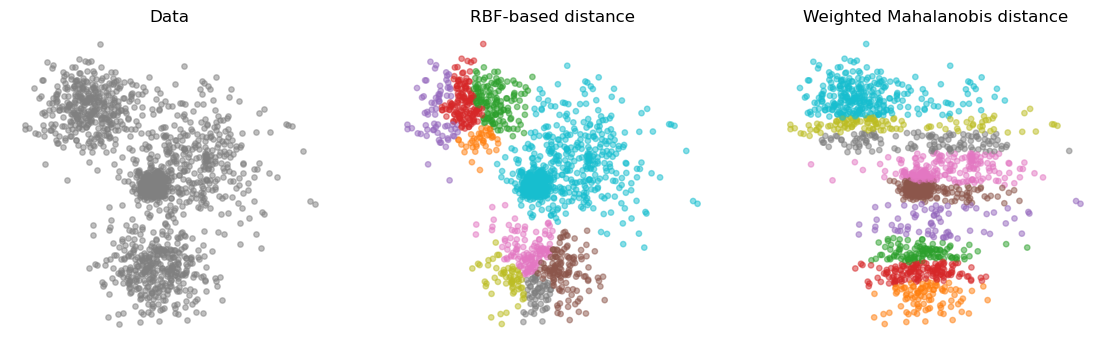

In [24]:
_, axes = plt.subplots(1,3, figsize=(14,4))
plot_clusters(X, title="Data", ax=axes[0])
plot_clusters(X, title="RBF-based distance", clusters=partition_3, ax=axes[1])
plot_clusters(X, title="Weighted Mahalanobis distance", clusters=partition_4, ax=axes[2])

- It should be clear by now how great is the impact of the (dis)similarity measure in classification and clustering.
- But how to measure the distance between time series? 

---

## Time series similarity

- We will look at 3 families of approaches to compute a distance between time series:
    - Alignment-based metrics.
    - Time series kernels.
    - Vector distance on time series embeddings.
- Each approach comes with pros and cons.
- In the following, we will look at one representative for each faimily.

### Multivariate Time Series (MTS)

- The approaches we discuss in the following can be applied to datasets of MTS.
- An MTS is represented by a matrix $\mathbf{X} \in \mathbb{R}^{T \times V}$, where $T$ is the number of time steps and $V$ is the variables.
- The whole datatset can be represented by a 3-dimensional array `X` of size `[N, T, V]`.
- In a classification setting, the $i$-th MTS `X[i,:,:]` is associated with with a class label `y[i]`.

<img src="media/mts_data.png" style="width: 60%; display: block; margin: auto;">

**Example:** 
- Consider the [uWave](https://ieeexplore.ieee.org/document/4912759) MTS dataset.
- Each MTS represents the $(x,y,z)$ measurements of an accelerometer wore when doing one of the following gestures.
- The dot is the starting point, the arrow the end point.

<img src="media/UWaveGestureLibrary.jpg" style="width: 20%; display: block; margin: auto;">

In [25]:
def plot_uwave():
    X, Y, _, _ = DataLoader().get_data('UWAVE')
    _, axes = plt.subplots(3, 8, figsize=(15, 5), subplot_kw={'projection': '3d'})
    for i in range(len(np.unique(Y))):
        idx = np.where(Y == i+1)[0][:3]
        for j, id in enumerate(idx):
            axes[j,i].plot(X[id, :, 0], X[id, :, 1], X[id, :, 2], color=plt.cm.tab10(i))
            axes[j,i].set_xticks(())
            axes[j,i].set_yticks(())
            axes[j,i].set_zticks(())
            axes[j,i].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
            if j == 0:
                axes[j,i].set_title(f"Class {i+1}")
    plt.tight_layout()
    plt.show()

Loaded UWAVE dataset.
Number of classes: 8
Data shapes:
  Xtr: (200, 315, 3)
  Ytr: (200, 1)
  Xte: (428, 315, 3)
  Yte: (428, 1)


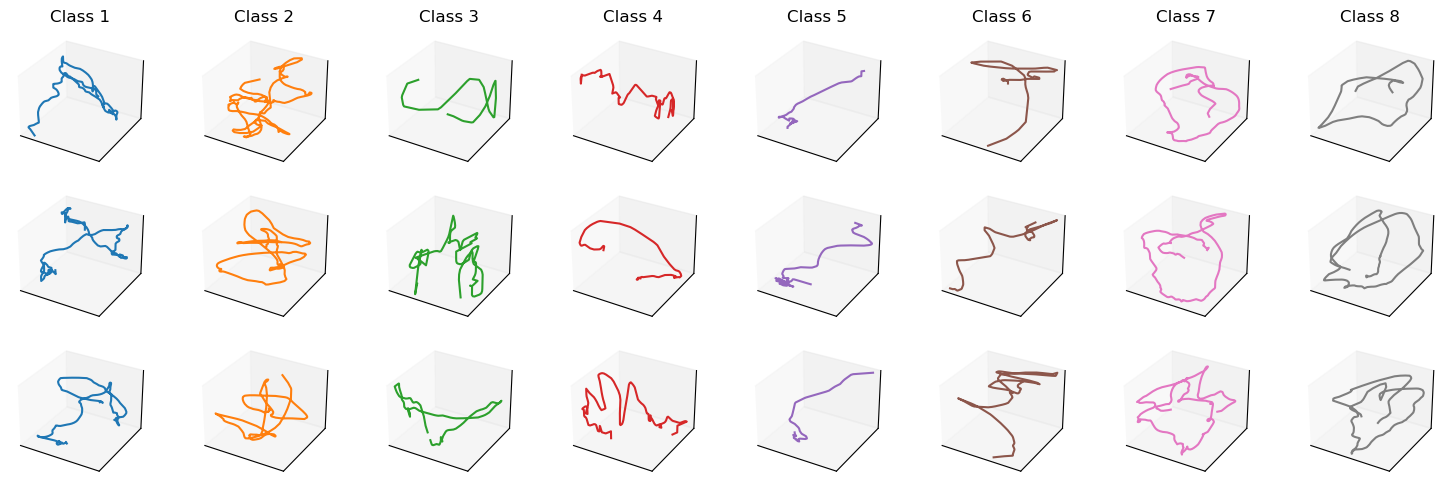

In [26]:
plot_uwave()

---

## Alignment-based metric: Dynamic Time Warping (DTW)

- An alignment-based metric relies on a temporal alignment of two time series to assess their similarity.
- One of the most prominent representatives of this class is Dynamic Time Warping (DTW).
- The idea of DTW is to first align two time series and then compute an Euclidean distance between the matched elements.

- Let's first consider a naïve approach.
- We compute a distance between all the time steps of two time series $\boldsymbol{x}$ and $\boldsymbol{y}$ of length $T_x$ and $T_y$, respectively: 

$$d(\boldsymbol{x}, \boldsymbol{y}) = \sum \limits_{t=1}^{\min(T_x, T_y)} \|x(t) - y(t)\|_2$$

- If the two time series are very similar but slightly disaligned, it will produce a large distance.

<img src="media/DTW_idea_1.gif" style="width: 40%; display: block; margin: auto;">

- DTW disregards the exact timestamps at which the observations occur.
- DTW seeks for the *temporal alignment* (a matching between time indexes of the two time series) that minimizes Euclidean distance between the aligned series.

<img src="media/DTW_idea_2.gif" style="width: 40%; display: block; margin: auto;">

### DTW algorithm

- DTW solves the following optimization problem:

$$\text{DTW}(\boldsymbol{x}, \boldsymbol{y}) = \min \limits_{\pi \in \mathcal{P}(\boldsymbol{x}, \boldsymbol{y})} \left( \sum \limits_{(i,j) \in \pi} d(x(i), y(j))  \right)$$

- $\pi$ is an *alignment path* of length $K$, i.e., a sequence of index pairs.
- $\mathcal{P}(\boldsymbol{x}, \boldsymbol{y})$ is the set of all admissible paths.

An admissible path should satisfy the following conditions:

1. The beginning and the end of the two time series are matched together.
    - $\pi_{1} = (1,1)$
    - $\pi_{K} = (T_x, T_y)$
    
<img src="media/start_end.png" style="width: 40%; display: block; margin: auto;">

2. The sequence is monotonically increasing in both $i$ and $j$ and all time series indexes should appear at least once.
    - $i_{k-1} \leq i_k \leq i_{k-1}+1$
    - $j_{k-1} \leq j_k \leq j_{k-1}+1$
    
<img src="media/conditions.png" style="width: 40%; display: block; margin: auto;">

- The DTW path can be represented by a binary matrix $\mathbf{P}_\pi$ whose non-zero entries are those corresponding to a matching between time series elements: 

$$(\mathbf{P}_\pi)_{i,j} = \begin{cases}1 &= \text{if}\; (i,j)\in \pi \\ 0 &= \text{otherwise}\end{cases}$$


- Using the matrix notation, DTW can be rewritten as 

$$\text{DTW}(\boldsymbol{x}, \boldsymbol{y}) = \min \limits_{\pi \in \mathcal{P}(\boldsymbol{x}, \boldsymbol{y})} \langle \mathbf{P}_\pi, \mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}} \rangle$$

- where the $(i,j)^{th}$ element of $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}} \in \mathbb{R}^{T_x \times T_y}$ stores the distance $d(x(i), y(j))$.

<img src="media/matrix.png" style="width: 60%; display: block; margin: auto;">

#### Finding the optimal path

- First, we fill-up the cost matrix $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}}$.

<img src="media/cost.gif" style="width: 30%; display: block; margin: auto;">

- Then, we start traversing the matrix from the top-left corner $(1,1)$ to the bottom-right one $(T_x, T_y)$.
- Excluding the borders, at each step we have three options to decide where to go.
- Each path results in a different cost.
- The optimal path is the one with minimum cost... 🤔 But how to find it?

<img src="media/path.gif" style="width: 30%; display: block; margin: auto;">

- We need to compute the cost for each possible path.
- When $T_x=T_y$, the total number of paths is $\mathcal{O}\left(\frac{(3+2\sqrt{2})^{T_x}}{\sqrt{T_x}}\right)$.
- That is a big number: looking at all of them is intractable.

- There are many paths that share the same sections.
- To make the problem tractable, we must avoid recomputing the same paths over and over.

<img src="media/redundant.png" style="width: 30%; display: block; margin: auto;">

- We can use *recursion*, a dynamic programming technique that breaks down a complex problem into simpler sub-problems.
- Each sub-problem is solved just once and the solution is stored in memory. 
- When a sub-problem is encountered again, its solution is retrieved instead of being recomputed.
- This significantly reduces the number of computations cutting the redundancies.

- The recursive algorithm has complexity $\mathcal{O}(T_x T_y)$ and is formulated as follow:

```python
def DTWDistance(x, y):
  for i in range(len(x)):
    for j in range(len(y)):
      DTW[i, j] = d(x[i], y[j])
      if i > 0 or j > 0:
        DTW[i, j] += min(
          DTW[i-1, j  ] if i > 0             else inf,
          DTW[i  , j-1] if j > 0             else inf,
          DTW[i-1, j-1] if (i > 0 and j > 0) else inf
        )
  return DTW[-1, -1]
```

- The idea is that each block $(i,j)$ recursively ask to its predecessors $(i-1, j)$, $(i, j-1)$, and $(i-1, j-1)$ the cost to reach them.
- The request is propagated back to the origin $(1,1)$ wich returns the first answer.
- The answer is then propagated forward to all the requesters, which update the answer with their own cost.

<img src="media/recursion.gif" style="width: 40%; display: block; margin: auto;">

#### DTW properties

- The example below show how the DTW changes when two curves are translated and stretched/squeezed at the same time.


<img src="media/warping.gif" style="width: 45%; display: block; margin: auto;">

- Note that the distance influenced only by the "stretching/squeezing" part.
- In fact, the DTW is invariant to translation.

<img src="media/warping_fix.gif" style="width: 45%; display: block; margin: auto;">

- Note that is possible to add constraints that generate a cost if translation exceeds a certain limit.

<img src="media/warping_constrained.gif" style="width: 45%; display: block; margin: auto;">

#### DTW example

- Let's see DTW in action starting with a simple example.
- We generate two groups of time series using two different AR(1) processes.

In [27]:
T = 100 # Length of the time series
N = 30  # Time series per set

# Generate the first set of time series
Y1 = np.zeros((T, N))
for i in range(N):
    Y1[:,i] = sm.tsa.arma_generate_sample(ar=[1, -.9], ma=[1], nsample=T, scale=1) 

# Generate the second set of time series
Y2 = np.zeros((T, N))
for i in range(N):
    Y2[:,i] = sm.tsa.arma_generate_sample(ar=[1, .9], ma=[1], nsample=T, scale=1)

- Let's see how the mean and std of the two groups look like.

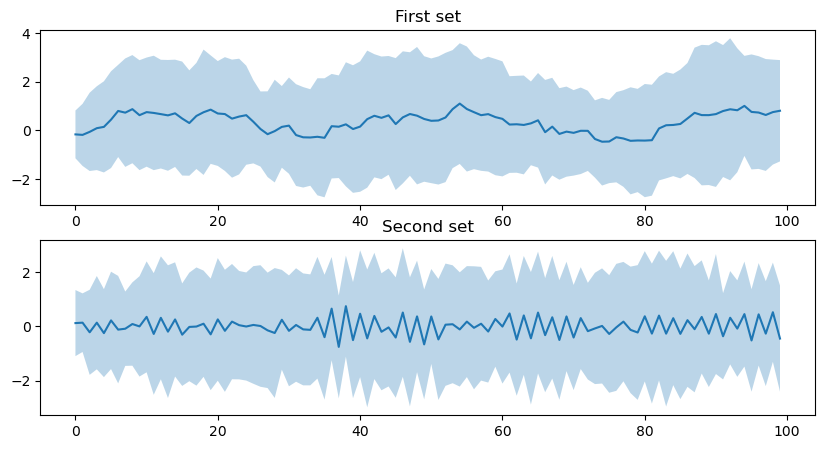

In [28]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
axes[0].plot(np.mean(Y1, axis=1))
axes[0].fill_between(range(T), np.mean(Y1, axis=1) - np.std(Y1, axis=1), np.mean(Y1, axis=1) + np.std(Y1, axis=1), alpha=0.3)
axes[0].set_title("First set")
axes[1].plot(np.mean(Y2, axis=1))
axes[1].fill_between(range(T), np.mean(Y2, axis=1) - np.std(Y2, axis=1), np.mean(Y2, axis=1) + np.std(Y2, axis=1), alpha=0.3)
axes[1].set_title("Second set");

- We can visualize the path $\pi$ on the cost matrix $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}}$ for the time series we generated.
- First, we let $\boldsymbol{x}$ and $\boldsymbol{y}$ be two time series from the same group.
- Notice how the path $\pi$ crosses the darker areas, corresponding to smaller dissimilarity values.

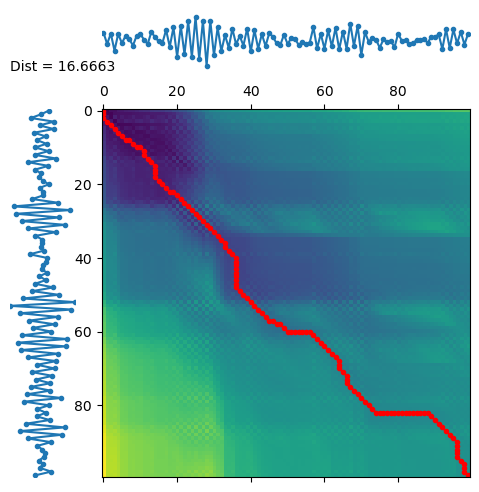

In [29]:
s1 = Y2[:,1]
s2 = Y2[:,2]
fig = plt.figure(figsize=(5, 5))
d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, figure=fig);

- Then, we select $\boldsymbol{x}$ and $\boldsymbol{y}$ from two different groups.
- We see how the dissimilarity is much higher in this case and the path $\pi$ changes significantly.

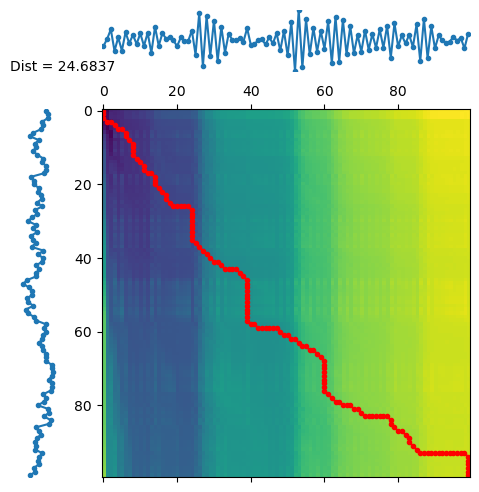

In [30]:
s1 = Y1[:,1]
s2 = Y2[:,1]
fig = plt.figure(figsize=(5, 5))
d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, figure=fig);

- Finally, we compute the DTW distance between all the time series in the two sets.

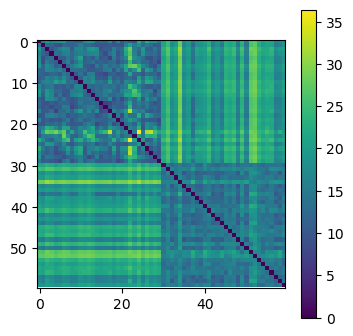

In [31]:
# Concatenate the two sets of time series
Y = np.concatenate((Y1, Y2), axis=1).T

# Compute the distance matrix
dtw_dist = dtw.distance_matrix_fast(Y)

plt.figure(figsize=(4,4))
plt.imshow(dtw_dist, cmap='viridis')
plt.colorbar();

- We see a clear block structure. 
- The dissimilarity is lower between time series of the same group.

- For comparison, we also compute the Euclidean distance between the time series.

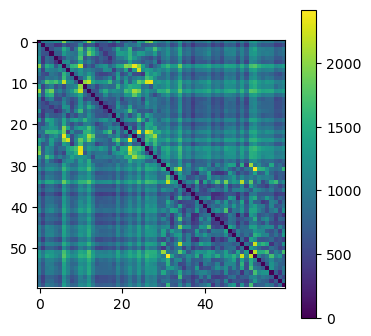

In [32]:
# compute euclidean distance between the time series
euc_dist = pairwise_distances(Y, metric="sqeuclidean")
plt.figure(figsize=(4,4))
plt.imshow(euc_dist, cmap='viridis')
plt.colorbar();

- This time the dissimilarity matrix is less structured and is harder to see the division in two groups.
- As expected, the Euclidean distance is less suitable for these type of data.

### Classification with DTW

- Now we turn to a real classification problem.
- We will use one of the following datasets.

In [33]:
DataLoader().available_datasets()

Available datasets:

AtrialFibrillation
ArabicDigits
Auslan
CharacterTrajectories
CMUsubject16
ECG2D
Japanese_Vowels
KickvsPunch
Libras
NetFlow
RobotArm
UWAVE
Wafer
Chlorine
Phalanx
SwedishLeaf


In [34]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


In [35]:
# Concatenate X and Xte
X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)

In [36]:
# Compute the dissimilarity matrix
dtw_dist = dtw_ndim.distance_matrix_fast(X)
print("dist shape:", dtw_dist.shape)

dist shape: (640, 640)


- Note that we have concatenated the training and test set before computing the distances. Why?
- In the following, we will use an SVC with a pre-computed kernel, i.e., a custom similarity matrix (more details [here](https://scikit-learn.org/stable/modules/svm.html#custom-kernels)).
- There are two sets of distances we need to compute to provide the information to the classifier.

- For training, we need the distances between elements in the training set.
    - Let's call the matrix containing these distances **tr-tr**.
- For testing, we need the distances between the training and test set elements.
    - These distances are in the matrix **te-tr**.

<img src="media/dist_matrix.png" style="width: 35%; display: block; margin: auto;">

- Unfortunately, `dtw_ndim.distance_matrix_fast` does not compute distances across two different sets, meaning that it cannot compute **te-tr** explicitly.
- In our case, since the dataset is small, we can compute the whole distance matrix and keep only the parts we need.
- Note that some computations (**tr-te** and **te-te**) are *wasted*.
- If the computing resources are limited or the dataset is too large, it's better to iterate through the elements of the training and test set and compute only the distances that we actually need.

- The kernel is a similarity matrix with elements in [0,1].
- We can obtain it with the following transformation. 

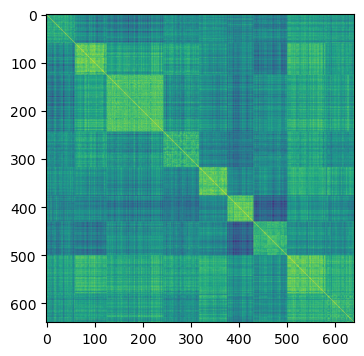

In [37]:
dtw_sim = 1.0 - dtw_dist/dtw_dist.max()

# Plot the similarity matrix
idx_sorted = np.argsort(Y[:,0])
dtw_sim_sorted = dtw_sim[:,idx_sorted][idx_sorted,:]
fig =  plt.figure(figsize=(4,4))
plt.imshow(dtw_sim_sorted);

- Next, we extract the kernels that we actually need.

In [38]:
sim_trtr = dtw_sim[:Xtr.shape[0], :Xtr.shape[0]]
print(sim_trtr.shape)

sim_tetr = dtw_sim[Xtr.shape[0]:, :Xtr.shape[0]]
print(sim_tetr.shape)

(270, 270)
(370, 270)


- Finally we train the classifier and compute the classification performance on the test data.

In [39]:
clf = svm.SVC(kernel='precomputed', C=1).fit(sim_trtr, Ytr.ravel())
y_pred = clf.predict(sim_tetr)
accuracy = accuracy_score(Yte.ravel(), y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.30%


#### $k$-NN classifier

- Once computed, the distance/similarity matrix can seamlessly be used with other classifiers.
- One example is the classic the $k$-NN classifier, which simply implements a majority vote:
    - A test sample is assigned the most frequent class among its $k$ nearest neighbors ($k$-NN) in the training set.
- In our case, the neighbors are identified based on the DTW distance.

In [40]:
# In this case we use the DTW distance directly.
dtw_trtr = dtw_dist[:Xtr.shape[0], :Xtr.shape[0]]
dtw_tetr = dtw_dist[Xtr.shape[0]:, :Xtr.shape[0]]

In [41]:
neigh = KNeighborsClassifier(n_neighbors=3, metric='precomputed') # specify k=3
neigh.fit(dtw_trtr, Ytr.ravel())
y_pred = neigh.predict(dtw_tetr)
accuracy = accuracy_score(Yte.ravel(), y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.49%


### Clustering with DTW

- To perform clustering we can use HC.
- As before, we will use Ward Linkage to generate the hierarchy `Z`.
- We need to pass the DTW dissimilarity matrix.

In [42]:
distArray = ssd.squareform(dtw_dist)
Z = linkage(distArray, 'ward') 

- To obtain the acutal clusters we need to put a threshold.
- To select the threshold, we look at the hierarchy `Z` with a dendrogram plot.

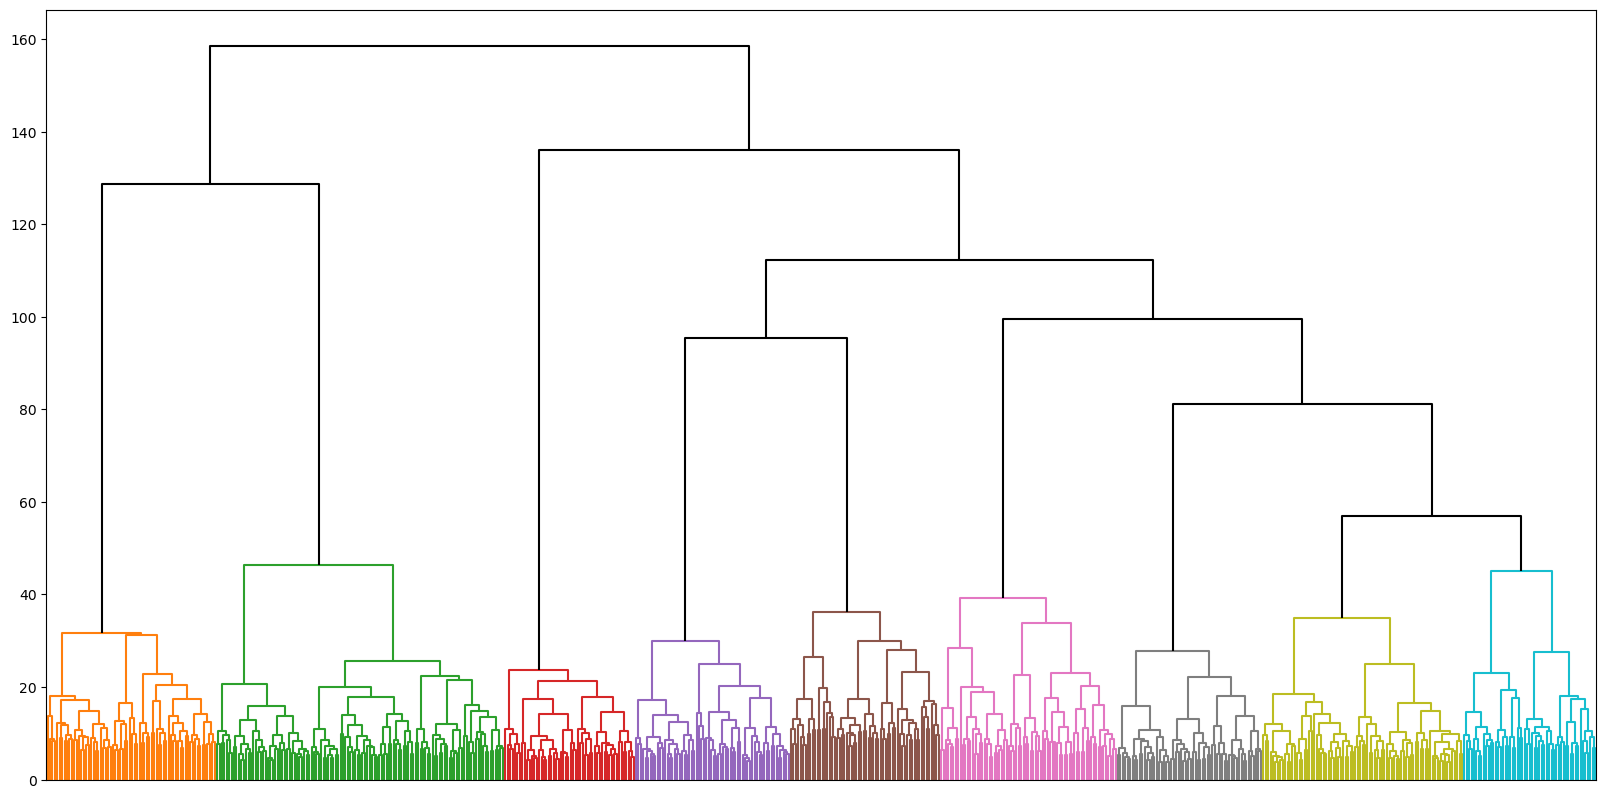

In [43]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=50, above_threshold_color='k', 
                show_leaf_counts=False)
plt.xticks([]);

- A value between 50 and 60 seems to give a stable partition.

In [44]:
partition = fcluster(Z, t=55, criterion="distance")
print(f"Found {len(np.unique(partition))} clusters")

Found 9 clusters


- Finally, we compute the agreement between the partition and the actual class labels.

In [45]:
print(f"DTW-based clustering NMI: {v_measure_score(partition, Y.ravel()):.2f}")

DTW-based clustering NMI: 0.95


### Visualization through dimensionality reduction

- How can we visualize our dataset in a meaningful way?
- We have $N$ samples, each one representing a multivariate time series of size $T \times V$.
- Plotting them directly is impossible.

- In a previous lecture we encountered PCA, a technique to reduce the data dimensionality.
- Reducing data to 2 or 3 dimension would make visualization possible.

- If the data are vectors, i.e., $\mathbf{X} \in \mathbb{R}^{N \times V}$, PCA first computes the empirical correlation matrix $\mathbf{X}^\top\mathbf{X} \in \mathbb{R}^{V \times V}$ that captures the covariance among the features in the dataset. 
- PCA uses this information to project the data onto the directions (principal components) that maximize variance.
- Unfortunately, the empirical correlation is meaningless if the data are time series because we are not interested in the correlation of individual time steps.
- The problem further complicates if the time series are multivariate.

- PCA can compute the principal components also through the eigendecomposition of the Gram matrix $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{N \times N}$.
- The Gram matrix is a covariance matrix, i.e., a similarity matrix that captures linear relationships between data samples.
- As with the Euclidean distance, a linear covariance matrix is not suitable for time series.
- However, we can replace the covariance with another kernel matrix, such as the one derived from DTW.
- The PCA algorithm that uses kernel matrices is called [KernelPCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html).

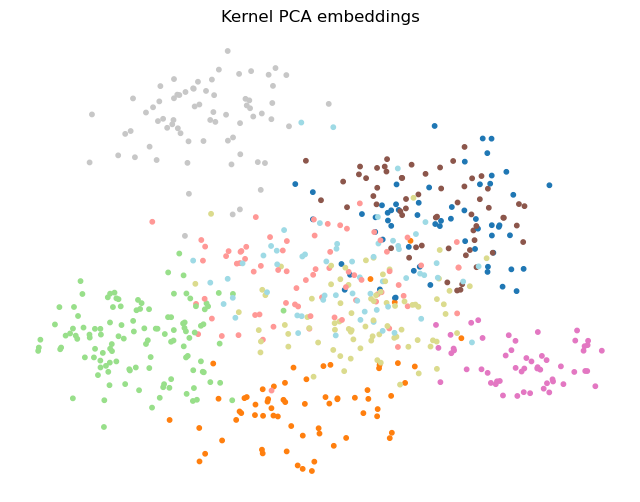

In [46]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(dtw_sim)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(()); plt.yticks(());

- KernelPCA maps each time series to a 2D point.
- The DTW-based similarity caputures well the structure of the data and the relationships among the time series.
- As a result, KernelPCA projects the classes in relatively well-separated groups.

---

## Time-series kernels

- A kernel for time series data is a mathematical function used to measure the similarity between two time series 

$$k(\boldsymbol{x}, \boldsymbol{y}) \geq 0$$

- We will consider the [Time Series Cluster Kernel (TCK)](https://github.com/FilippoMB/Time-series-cluster-kernel), which offers the following advanages
    - Suitable for multi-variate time series.
    - Can deal with missing data.
    - Robust to hyperparameters selection.

- To build a kernel, TCK combines *Gaussian Mixture Models (GMM)* with an *ensemble learning* approach.

<img src="media/tck_scheme.png" style="width: 90%; display: block; margin: auto;">

### GMM

- A GMM assumes that all the data points are generated from a mixture of $C$ Gaussian distributions (components) with unknown parameters $\{ \mu_c, \Sigma_c \}_{c=1}^C$. 
- GMMs are used for clustering.
- Each cluster is modeled by a Gaussian distribution. 

In [47]:
def plot_gmm(X, n_components, ax=None):

    gmm = GaussianMixture(n_components=n_components, covariance_type="full", random_state=0)
    gmm.fit(X)

    if ax is None:
        _, ax = plt.subplots(1,1,figsize=(6, 6))

    # Plot data
    ax.scatter(X[:, 0], X[:, 1], c='gray', s=10, alpha=0.5, edgecolors='gray')
    
    # Plot ellipses
    for n in range(gmm.n_components):
        color = plt.cm.tab10(n)
        covariances = gmm.covariances_[n][:2, :2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    ax.set_xticks(())
    ax.set_yticks(())

In [48]:
# Create toy data
X, y = datasets.make_classification(n_samples=950, n_features=2, n_informative=2, 
                                    n_redundant=0, n_clusters_per_class=1, random_state=4, 
                                    n_classes=3, class_sep=1.5, flip_y=0.1)

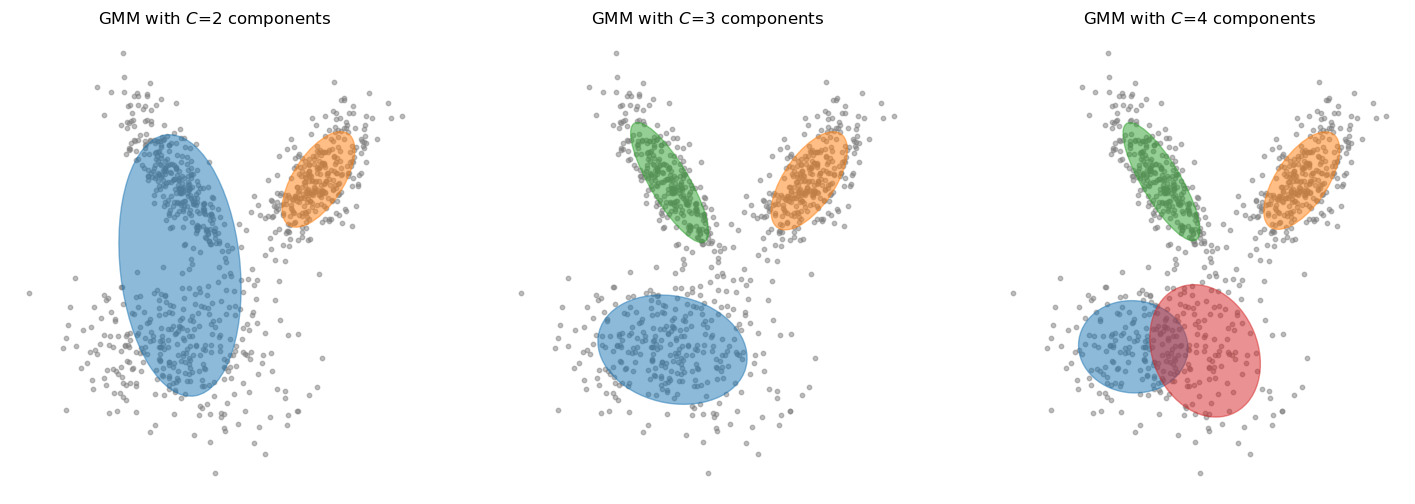

In [49]:
_, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, n in enumerate([2, 3, 4]):
    plot_gmm(X, n, ax=axes[i])
    axes[i].set_title(f"GMM with $C$={n} components")

Mathematically, a GMM is defined as:

$$p(x) = \sum_{c=1}^{C} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c)$$

- $\pi_c$ is the mixing coefficient of the $c$-th Gaussian, with $0 \leq \pi_c \leq 1$ and $\sum_{c=1}^{C} \pi_c = 1$.
- $\pi_c$ indicates how much a data point $x$ belongs to the $c$-th Gaussian $\mathcal{N}(x | \mu_c, \Sigma_c)$.

- Clustering with GMM involves estimating the parameters $\pi_c$, $\mu_c$, and $\Sigma_c$ using the Expectation-Maximization (EM) algorithm:
    - The EM algorithm iteratively assigns data points to clusters (expectation step).
    - Then, updates the parameters to maximize the likelihood of the data given the current clusters (maximization step). 
- In the end, each data point is assigned with a probability of belonging to each cluster.
- The output is a *soft clustering* where points can belong to multiple clusters with different probabilities.

- The output can be represented by a *soft cluster assignment matrix* $\boldsymbol{\Pi} \in \mathbb{R}^{N \times C}$.
- The $(i,c)$-th element of $\boldsymbol{\Pi}$ is the membership of the MTS $i$ to cluster $c$: $\boldsymbol{\Pi}[i,c] = \pi^{(i)}_c$.
- The $i$-th row of $\boldsymbol{\Pi}$ represents all the memberships of the $i$-th MTS: $\boldsymbol{\Pi}[i,:] = \Pi^{(i)}$.

- Crisp cluster assignments (cells in gray in the figure) are obtained by taking the maximum value in $\Pi^{(i)}$.

<img src="media/soft_clust.png" style="width: 35%; display: block; margin: auto;">

### GMM for time series with missing data

TCK modifies the standard GMM model in two ways.

1. To handle *time series data*, the means of the GMM components become multi-variate time series.
    - Standard GMM: $\boldsymbol{\mu}_c \in \mathbb{R}^V$.
    - TCK GMM: $\boldsymbol{\mu}_c \in \mathbb{R}^{T \times V}$.

2. To handle missing values, TCK puts priors on the GMM parameters and replaces the EM algorithm with Maximum a-posteriori (MAP) estimation.
    - EM: $\boldsymbol{\hat \mu},  \boldsymbol{\hat \Sigma} = \text{argmax}_{\boldsymbol{\mu}, \boldsymbol{\Sigma}} p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$.
    - MAP with priors: $\boldsymbol{\hat \mu},  \boldsymbol{\hat \Sigma} = \text{argmax}_{\boldsymbol{\mu}, \boldsymbol{\Sigma}} p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) p(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
- The resulting means are smoother and the parameters are similar to the overall mean and covariance in clusters with few samples.

<img src="media/map.png" style="width: 65%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://dl.acm.org/doi/abs/10.1145/2110363.2110408">Marlin at al., 2012</a></div>

#### Ensemble learning

- Ensemble approach: combine many weak models to obtain a more powerful one.
- Reduces the sensitivity to hyperparameters selection.
- Can produce a well-defined kernel.

- The ensemble of GMMs is obtained by fitting $G$ different GMMs on:
    - A subset of the $N$ MTS in the dataset.
    - A subset of the $V$ variables.
    - A segment of indices of length $\leq T$ in the time series.
    
<img src="media/ensemble.png" style="width: 100%; display: block; margin: auto;">

- The kernel matrix is obtained by combining the clustering results from the $G$ GMMs in the ensemble.
- Specifically, $k(\boldsymbol{x}, \boldsymbol{y})$ is proportional to how many times $\boldsymbol{x}$ and $\boldsymbol{y}$ are assigned to the same GMM:

$$k(\boldsymbol{x}, \boldsymbol{y}) = \sum \limits_{g \in G} \Pi^{(\boldsymbol{x})}(g)^\top \Pi^{(\boldsymbol{y})}(g)$$

### Classification with TCK

- We load the same data as before.

In [50]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- One of the main advantages of TCK is the ability in handling missing values.
- From the previous data, we randomly remove 40% of the data by setting the values to `np.nan`.

In [51]:
mask_tr = np.random.choice([0, 1], size=Xtr.shape, p=[0.6, 0.4])
Xtr[mask_tr == 1] = np.nan
mask_te = np.random.choice([0, 1], size=Xte.shape, p=[0.6, 0.4])
Xte[mask_te == 1] = np.nan

- We create a TCK kernel with `G=30` GMMs, each with `C=15` components.
    - In general, the higher the values of `G` the better the performance but the higher the computation time.
    - `C` controls the model complexity. Too low $\rightarrow$ underfit, too high $\rightarrow$ overfit.
- Then, we fit TCK on the training data.
- As in the DTW case, we compute the two kernels $K_\text{tr-tr}$ and $K_\text{tr-te}$ to train and test our classifier.

In [52]:
tck = TCK(G=30, C=15)
Ktr = tck.fit(Xtr).predict(mode='tr-tr')
Kte = tck.predict(Xte=Xte, mode='tr-te').T
print(f"Ktr shape: {Ktr.shape}\nKte shape: {Kte.shape}")

The dataset contains missing data

Training the TCK using the following parameters:
	C = 15, G = 30
	Number of MTS for each GMM: 216 - 270 (80 - 100 percent)
	Number of attributes sampled from [2, 11]
	Length of time segments sampled from [6, 23]




Fitting GMMs:   0%|          | 0/420 [00:00<?, ?it/s]

Computing TCK (tr-tr):   0%|          | 0/420 [00:00<?, ?it/s]

Computing TCK (tr-te):   0%|          | 0/420 [00:00<?, ?it/s]

Ktr shape: (270, 270)
Kte shape: (370, 270)


**💡 Tip**
- If TCK is taking too long, try reducing the number of GMMs (`G`) or the number of components (`C`).

In [53]:
clf = svm.SVC(kernel='precomputed').fit(Ktr, Ytr.ravel()) # Train
Ypred = clf.predict(Kte) # Test
print(f" Test accuracy: {accuracy_score(Yte, Ypred):.2f}") 

 Test accuracy: 0.94


- Even with 40% of missing data, with TCK we maintain a good classification performance.

---

## Time-series embedding

- The last approach we consider is to embed the whole MTS into a real-valued vector.
- Doing that allows us to use standard (dis)similarity measures for vectorial data (cosine similarity, Euclidean distance, etc...).
- The key problem is how to embed the temporal information into a static vector in a meaningful way.

- There are many approaches for extracting static features from a time series.
- For example, see [here](https://github.com/fraunhoferportugal/tsfel) for a collection of simple techniques.
- In this lecture, we will focus on Reservoir Computing (RC) to generate embeddings of MTS.

### RC framework

- We will rely on the [RC framework for MTS classification and clustering](https://reservoir-computing.readthedocs.io/en/latest/).

<img src="media/RC_classifier.png" style="width: 90%; display: block; margin: auto;">

- The RC framework consists of 4 modules:
    1. Reservoir module.
    2. Dimensionality reduction module.
    3. MTS representation module.
    4. Readout module.

#### Reservoir module

- This module generates a sequence of Reservoir states from a given MTS $\boldsymbol{x}$ as 

$$\mathbf{h}(t) = \sigma \left(\mathbf{W}_i \boldsymbol{x}(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$

- If we have $N$ MTS they can be processed in parallel by the Reservoir and generate the sequence of states 

$$\{\mathbf{H}(1), \mathbf{H}(2), \dots, \mathbf{H}(T)\}$$ 

- with $\mathbf{H}(t) \in \mathbb{R}^{N \times H}$.  

- The Reservoir can operate in two modalities:
    1. Unidirectional.
    2. Bidirectional.

**Unidirectional Reservoir**
- This is the same Reservoir we saw in the previous lectures.
    - Input: MTS data `X` of shape `[N, T, V]`.
    - Output: a sequence of states `H` of shape `[N, T, H]`.
    
<img src="media/unidir.png" style="width: 30%; display: block; margin: auto;">

**Bidirectional Reservoir**
- This Reservoir processes the time series also backwards.
- This allows to retrieve context from both past and future data points capture more complex and longer temporal dependencies.
    - Input: MTS data `X` of shape `[N, T, V]`.
    - Output: a sequence of states `H` of shape `[N, T, 2*H]`.

<img src="media/bidir.png" style="width: 30%; display: block; margin: auto;">

**⚠️ Attention**

- A Bidirectional Reservoir is not *causal*. 
- It cannot be used for forecasting but is suitable for classification and clustering.

In [54]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


In [55]:
H_uni = Reservoir(n_internal_units=300).get_states(Xtr, bidir=False)
print(f"Unidir\n  H: {H_uni.shape}")

H_bi = Reservoir(n_internal_units=300).get_states(Xtr, bidir=True)
print(f"Bidir\n  H: {H_bi.shape}")

Unidir
  H: (270, 29, 300)
Bidir
  H: (270, 29, 600)


#### Dimensionality reduction module (optional)

- This module reduces the dimensionality of the Reservor states from `[N,T,H]` (or `[N,T,2*H]`) to `[N,T,R]`.
- This module is optional, i.e., dimensionality reduction can be skipped.
- However, it drammatically speed up computations especially when using more advanced representations (more details soon).
- Dimensionality reduction can be implemented by 
    1. Standard PCA
    2. Tensor PCA

<img src="media/dim_red.png" style="width: 30%; display: block; margin: auto;">

**Standard PCA**
- Standard PCA only works on uni-dimensional data.
- Reshape `H` from `[N,T,H]` to `[N*T,H]`.
- Apply PCA and keep the first `R` components.
- Reshape `[N*T,R]` back to `[N,T,R]`.
- ⚠️ Problem: the sample and the time steps are mixed up and modes of variation in time within individual samples are ingored.

**Tensor PCA**

- Compute the following covariance matrix 

$$\mathbf{S} = \frac{1}{N-1} \sum \limits_{n=1}^N (\mathbf{H}_n - \mathbf{\bar H})^\top (\mathbf{H}_n - \mathbf{\bar H}) \in \mathbb{R}^{H \times H}$$

- where $\mathbf{H}_n \in \mathbb{R}^{T \times H}$ is obtained as `H[n,:,:]` and $\mathbf{\bar H} = \frac{1}{N} \sum \limits_{n=1}^N \mathbf{H}_n \in \mathbb{R}^{T \times H}$.
- This allows to compute the variations across the Reservoir dimension by keeping sample- and time-dimension separated.

- Then, we take the first $R$ eigenvectors of $\mathbf{S}$: $\mathbf{D} = [\mathbf{u}_1, \mathbf{u}_2, \dots, \mathbf{u}_R]\in \mathbb{R}^{H \times R}$. 
- We obtain the reduced states with the following matrix multiplication: $\mathbf{\hat H}_n = \mathbf{H}_n \mathbf{D}$.

In [56]:
H_red = tensorPCA(n_components=75).fit_transform(H_bi)
print(f"H_red: {H_red.shape}")

H_red: (270, 29, 75)


#### Representation module

- This module is responsible of transforming the sequence of Reservoir states into a vectorial representation $\mathbf{r}_\mathbf{X}$.
- The Reservoir extracts and separates the dynamical features.
- In addition, it keeps a memory of all the past input.
- Therefore, in some cases, is sufficient to keep only the *last Reservoir state* to represent the whole MTS.

<img src="media/last_state.png" style="width: 10%; display: block; margin: auto;">

In [57]:
rx_last = H_red[:,-1,:]
print(f"rx_last: {rx_last.shape}")

rx_last: (270, 75)


- In practice, even when using a bidirectional Reservoir, this simple representation might fail to capture important information in the middle of the time series.

**Output model space**

- A more effective representation is obtained as follows.
  1. Train a linear readout to predict the MTS one step-ahead 

  $$\boldsymbol{x}(t+1) =  \mathbf{h}(t)\mathbf{W}_o + \mathbf{w}_o$$

  2. The parameters of the linear model $\boldsymbol{\theta}_o = [\text{vec}(\mathbf{W}_o); \mathbf{w}_o] \in \mathbb{R}^{V(R+1)}$ become the $\mathbf{r}_\mathbf{X}$.

<img src="media/output_ms.png" style="width: 12%; display: block; margin: auto;">

In [58]:
out_pred = Ridge(alpha=1.0)

# If we use a bidirectional Reservoir we also need to predict the time series backwards
X = np.concatenate((Xtr, Xtr[:, ::-1, :]), axis=2)         

coeff, biases = [], []
for i in range(X.shape[0]):
    out_pred.fit(H_red[i, 0:-1, :], X[i, 1:, :])
    coeff.append(out_pred.coef_.ravel())
    biases.append(out_pred.intercept_.ravel())
rx_out = np.concatenate((np.vstack(coeff), np.vstack(biases)), axis=1)

print(f"rx_out: {rx_out.shape}") # [N, 2*V*(R+1)]

rx_out: (270, 1824)


**Reservoir model space**

- A similar approach is to use the coefficients of a linear model that predicts the next state of the Reservoir 

$$\mathbf{h}(t+1) =  \mathbf{h}(t)\mathbf{W}_h + \mathbf{w}_h$$

- The MTS representation $\mathbf{r}_\mathbf{X}$ becomes $\boldsymbol{\theta}_h = [\text{vec}(\mathbf{W}_h); \mathbf{w}_h] \in \mathbb{R}^{R(R+1)}$.

<img src="media/reservoir_ms.png" style="width: 15%; display: block; margin: auto;">

In [59]:
res_pred = Ridge(alpha=1.0)

coeff, biases = [], []
for i in range(H_red.shape[0]):
    res_pred.fit(H_red[i, 0:-1, :], H_red[i, 1:, :])
    coeff.append(res_pred.coef_.ravel())
    biases.append(res_pred.intercept_.ravel())
rx_res = np.concatenate((np.vstack(coeff), np.vstack(biases)), axis=1)

print(f"rx_res: {rx_res.shape}") # [N, R*(R+1)]

rx_res: (270, 5700)


- In principle, the Reservoir model space $\boldsymbol{\theta}_h$ provides a better representation than the Output model space $\boldsymbol{\theta}_o$. Why 🤔?

- The Reservoir generates a large pool of dynamics but only few are needed to predict the input at a specific forecast horizon, i.e., 1 if we predict $\boldsymbol{x}(t+1)$.
- Not being useful for the task, the other dynamics are discarded even if they are still useful to characterize the MTS.

- On the other hand, to predict the next Reservoir state $\mathbf{h}(t+1)$ is necessary to consider *all* Reservoir dynamics.
- This makes $\boldsymbol{\theta}_h$ a more powerful representation as it fully characterizes the MTS.

#### Readout module

- The readout module is responsible to classify or cluster the MTS representations.
- Being each representation $\mathbf{r}_\mathbf{X}$ a vector, any standard classifier for vectorial data can be used.
- Similarly, we can use standard (dis)similarity measures for vectorial data.
- For example, clustering can be done using the Linkage aglorithm on the Euclidean distances between MTS representations.

### Classification with RC embeddings

- We can use the high-level function `RC_model` to perform the classification.
- The function takes as input the hyperparameters to configure:
    1. the Reservoir module,
    2. the dimensionality reduction module,
    3. the representation module,
    4. the readout module.
- To keep things clean, let's store the hyperparameters in a Python dictionary.

In [60]:
config = {}

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.9         # largest eigenvalue of the reservoir
config['leak'] = None                   # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circle'] = False                # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] = 'tenpca'      # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation: {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

- We create a RC classifier by passing the configuration parameters.

In [61]:
classifier =  RC_model(**config)

- We load again the data (good practice to be sure of getting clean data).

In [62]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- The RC model expects class labels to be one-hot-encoded, e.g.
- $1 \rightarrow [1, 0, 0, 0 \dots, 0]$, $2 \rightarrow [0, 1, 0, 0 \dots, 0]$, $3 \rightarrow [0, 0, 1, 0 \dots, 0]$, etc..

In [63]:
# One-hot encoding for labels
onehot_encoder = OneHotEncoder(sparse_output=False)
Ytr = onehot_encoder.fit_transform(Ytr)
Yte = onehot_encoder.transform(Yte)

In [64]:
# Train the model
tr_time = classifier.fit(Xtr, Ytr) 

Training completed in 0.01 min


In [65]:
# Compute predictions on test data
pred_class = classifier.predict(Xte) 
accuracy, f1 = compute_test_scores(pred_class, Yte)
print(f"Accuracy = {accuracy:.3f}, F1-score = {f1:.3f}")

Accuracy = 0.981, F1-score = 0.981


- Note how this approach is significantly faster than the other we have seen so far.

### Clustering with RC embeddings

- We will perform the following steps:

    1. Generate the vectorial representations for all MTS.
    2. Compute a dissimilarity matrix.
    3. Perform clustering with the distance-based HC algorithm Linkage.

- Since we are doing clustering, we do not need the train/test split.
- We concatenate the data from both sets together.

In [66]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- We can re-use the same `RC_model` as before.
- The only difference is that we do not want to apply the readout module.
- Instead, it should return the MTS representations.
- This is achieved by setting `'readout_type'`to `None`. 

In [67]:
config['readout_type'] = None # We update this entry from the previous config dict

In [68]:
# Instantiate the RC model
rcm =  RC_model(**config)

# Generate representations of the input MTS
rcm.fit(X)
mts_representations = rcm.input_repr

Training completed in 0.02 min


- At this point, we compute the distance matrix using standard metrics for vectorial data.
- For example, we can use the Euclidean or a Cosine distance.
- The latter is often preferred in high-dimensional spaces because Euclidean distance can become inflated and less meaningful ("curse of dimensionality").

In [69]:
# Compute Dissimilarity matrix
Dist = cosine_distances(mts_representations)
distArray = ssd.squareform(Dist)

# Hierarchical clustering
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=4.0, criterion="distance")
print(f"Found {len(np.unique(clust))} clusters")

# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print(f"Normalized Mutual Information (v-score): {nmi:.3f}")

Found 9 clusters
Normalized Mutual Information (v-score): 0.889


---

## Summary

This is what we covered in this lecture.
- We first introduced the problem of classification and clustering for vectorial data and the importance of choosing a proper measure for computing (dis)similarities among samples.

- Then, we introduced three approaches to compute (dis)similarities across multivariate time series.
    1. DTW, an alignment based-metric.
    2. TCK, a kernel similarity.
    3. RC embeddings, an approach to embed time series into vectors.
- These (dis)similarity measures are the cornerstone in time series classification and clustering.
- Once computed, we saw how they can be easily plugged into the same classification and clustering method we saw for vectorial data.

We conclude by highlighting the main pros and cons of the three approaches to compute MTS (dis)similarity.

**DTW**

- ✅ In most cases, works well with default hyperparameters.
- ✅ Invariant to translations in time.
- ❌ Slow.
- ❌ Does not account for complex dynamical features.

**TCK**

- ✅ Hyperparameters are easy to set.
- ✅ Handles missing data.
- ❌ Very slow.

**RC-embedding**

- ✅ Fast.
- ✅ Captures complex dynamical features.
- ❌ Many hyperparameters to set.

- Each approach can achieve better or worse performance depending on the data and the problem at hand.
- Selecting the optimal (dis)similarity measure, classification/clustering algorithm, and hyperparameters is often a difficult procedure.
- It requires experience and should be performed with systematic approaches such as cross-validation.

---

## Exercises

We will consider the [Libras](https://www.timeseriesclassification.com/description.php?Dataset=Libras) dataset. The dataset contains 15 classes of 24 instances each. Each class references to a hand movement type in LIBRAS (Portuguese name 'LÍngua BRAsileira de Sinais', oficial brazilian signal language).

In [70]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)


### Exercise 1

1. Compute the DTW distance matrix.
2. Obtain a similarity matrix from it.
3. Plot the two matrices. Comment about the structure you see (remember to sort the elements class-wise).
4. Perform classification with SVC and $k$-NN classifiers and report:
    - the training and test times,
    - the accuracy and the F1 score on the test set.
5. Perform hierarchical clustering using the Linkage Ward algorithm.
6. Plot a dendrogram and inspect it to select the optimal threshold to generate the clustering partition. Report the NMI for the partition you found.
7. Perform dimensionality reduction with KernelPCA. Plot the results in a 2-dimensional plot.

### Exercise 2

1. Add 40% of missing values to the training and test data.
2. Compute the TCK kernel.
3. Compute a dissimilarity matrix from the kernel (try to do the complementary of what you did to obtain a similarity from DTW). 

Repeat points 4-7 from the previous exercise.

### Exercise 3

1. Compute the RC embeddings.
2. Obtain a similarity and a dissimilarity matrix from the MTS representations.

Repeat points 4-7 from the previous exercises.